In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from tcn_keras import TemporalBlock, TemporalConvNet

from sklearn.metrics import mean_squared_error

plt.style.use(['dark_background'])

In [ ]:
# from assets import regression_performance, prediction_graph

In [121]:
def regression_performance(y_pred, y_true, print_results=False):
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    assert len(y_pred)  ==  len(y_true)
    res =   0
    for i, j in zip(y_true, y_pred):
        if 0.95*i <= j <= 1.05*i:
            res +=  1
    rmse    =   np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))

    current =   np.roll(y_true, -1)
    target  =   np.where(y_true-current>0, 1, 0)
    target_pred =  np.where(y_pred-current>0, 1, 0)
    precision   =   100*sum(np.equal(target, target_pred)+np.zeros(len(y_true)))/len(y_true)
    performance =   res/len(y_pred)
    
    if print_results:
        print(f'RMSE: {rmse:.2f}')
        print(f'Performance Percentage: {performance:.2f}')
        # print(f'Precision: {precision:.2f}')
        print(f'R2 Score Test = {r2_score(y_true, y_pred): 0.3f}')
        print(f'MAE Test = {mean_absolute_error(y_true=y_true, y_pred=y_pred): 0.3f}')
    
    return performance, rmse, precision


In [3]:
def prediction_graph(y_pred, y_true, model_name=None, save_name=False):
    from matplotlib import pyplot as plt

    plt.figure()
    plt.plot(y_pred)
    plt.plot(y_true)
    title   = ' Prediction vs Real Price'
    if model_name:
        title   =   model_name + title
    plt.title(title)
    plt.ylabel('Price')
    plt.xlabel('Days')
    plt.legend(['Prediction', 'Real'], loc='upper left')
    plt.grid()
    plt.show()
    if save_name:
        plt.savefig(save_name)

In [4]:
data    =   pd.read_csv('../BTCUSD_2010_2021.csv', thousands=',')
data.Date   =   pd.to_datetime(data.Date)
data.rename(columns={'Price': 'Close', 'Vol.':'Volume'}, inplace=True)
data.drop('Change %', axis=1, inplace=True)
data=   data[['Open', "High", "Low", "Close", "Volume", 'Date']]
data['Volume']  =   data['Volume'].replace({'K': '*1e3', 'M': '*1e6', '-':'-1'}, regex=True).map(pd.eval).astype(int)
data    =   data.reindex(index=data.index[::-1])
data.index  =   pd.date_range(data.Date.iloc[0], data.Date.iloc[-1], freq='D')
data.drop('Date', axis=1, inplace=True)

In [104]:
train   =   data.loc['2010':'2020']
test    =   data.loc['2020':]

In [106]:
TIME_STEPS  =   14

def build_timeseries(mat, y_col_index, time_steps=TIME_STEPS):
    import numpy as np

    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, time_steps, dim_1))
    y = np.zeros((dim_0,))

    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    
    return x, y.reshape(len(y), 1).astype('float32')

In [107]:
x_train, y_train    =   build_timeseries(train.values, 3)
x_test, y_test      =   build_timeseries(test.values, 3)

In [8]:
class TCN(tf.keras.Model):
    def __init__(self, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)

        self.temporalCN = TemporalConvNet(num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = tf.keras.layers.Dense(output_size, kernel_initializer=init, activation='relu')

    def call(self, x, training=True):
        y = self.temporalCN(x, training=training)
        return self.linear(y[:, -1, :])   # use the last element to output the result

In [108]:
channel_sizes = [25, 25, 25]
kernel_size = 5
dropout = 0.05
model = TCN(1, channel_sizes, kernel_size=kernel_size, dropout=dropout)
optimizer = tf.optimizers.Adam()

BATCH_SIZE  =   180
train_dataset   =   tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(60, seed=1234).batch(BATCH_SIZE)

In [98]:
def Callback_EarlyStopping(LossList, min_delta=0.1, patience=20):
    #No early stopping for 2*patience epochs 
    if len(LossList)//patience < 2 :
        return False
    #Mean loss for last patience epochs and second-last patience epochs
    mean_previous = np.mean(LossList[::-1][patience:2*patience]) #second-last
    mean_recent = np.mean(LossList[::-1][:patience]) #last
    #you can use relative or absolute change
    delta_abs = np.abs(mean_recent - mean_previous) #abs change
    delta_abs = np.abs(delta_abs / mean_previous)  # relative change
    if delta_abs < min_delta :
        print("*CB_ES* Loss didn't change much from last %d epochs"%(patience))
        print("*CB_ES* Percent change in loss value:", delta_abs*1e2)
        return True
    else:
        return False

In [136]:
# run 

epochs = 40
loss_seq    =   []
for epoch in range(epochs):
    for batch, (train_x, train_y) in enumerate(train_dataset):
        
        # loss
        with tf.GradientTape() as tape:
            y = model(train_x, training=True)
            # assert y.shape == (batch_size, 10)
            loss    =   tf.reduce_mean(tf.square(y - train_y))
            # loss_seq.append(loss)
        gradient = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradient, model.trainable_variables))

        if batch % 100 == 0:
            print("Batch:", batch, ", Train RMSE:", np.sqrt(loss.numpy()))
        
    stopEarly = Callback_EarlyStopping(loss_seq, min_delta=0.1, patience=10)
    if stopEarly:
        print("Callback_EarlyStopping signal received at epoch= %d/%d"%(epoch,epochs))
        print("Terminating training ")
        break
    
    # Eval Acc
    pred    =   model(x_test, training=False)
    mse = mean_squared_error(y_test, pred)
    print("Epoch:", epoch, ", Test RMSE:", np.sqrt(mse), "\n---")


Batch: 0 , Train RMSE: 42.1492
Epoch: 0 , Test RMSE: 2876.9553 
---
Batch: 0 , Train RMSE: 28.85568
Epoch: 1 , Test RMSE: 2379.151 
---
Batch: 0 , Train RMSE: 27.900434
Epoch: 2 , Test RMSE: 1925.7904 
---
Batch: 0 , Train RMSE: 21.162943
Epoch: 3 , Test RMSE: 1704.9244 
---
Batch: 0 , Train RMSE: 27.54652
Epoch: 4 , Test RMSE: 1687.8821 
---
Batch: 0 , Train RMSE: 19.277811
Epoch: 5 , Test RMSE: 1979.6871 
---
Batch: 0 , Train RMSE: 18.975557
Epoch: 6 , Test RMSE: 1665.8287 
---
Batch: 0 , Train RMSE: 22.167307
Epoch: 7 , Test RMSE: 1419.8811 
---
Batch: 0 , Train RMSE: 25.683033
Epoch: 8 , Test RMSE: 1297.6324 
---
Batch: 0 , Train RMSE: 25.638535
Epoch: 9 , Test RMSE: 1455.5767 
---
Batch: 0 , Train RMSE: 20.349955
Epoch: 10 , Test RMSE: 1325.2738 
---
Batch: 0 , Train RMSE: 25.482399
Epoch: 11 , Test RMSE: 1286.7537 
---
Batch: 0 , Train RMSE: 25.968666
Epoch: 12 , Test RMSE: 1275.9089 
---
Batch: 0 , Train RMSE: 24.7851
Epoch: 13 , Test RMSE: 1321.4357 
---
Batch: 0 , Train RMSE: 

In [137]:
pred = model(x_test)

In [139]:
performance, rmse, precision = regression_performance(pred, y_test, print_results=True)

RMSE: 1815.44
Performance Percentage: 0.55
R2 Score Test =  0.989
MAE Test =  1290.783


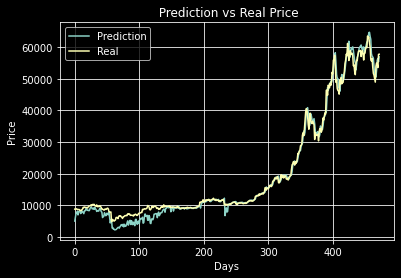

In [140]:
prediction_graph(pred.numpy(), y_test)